In [1]:
import os
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import patches
import matplotlib.pyplot as plt
import pandas as pd


DATA_ROOT = "/Users/andrewgrowney/Data/kaggle/marchmadness-2023"
teams_df = pd.read_csv(f"{DATA_ROOT}/Stage2/MTeams.csv")
%matplotlib widget

In [2]:
def get_team_name(team_id):
    return teams_df[teams_df['TeamID'] == team_id]['TeamName'].values[0]

Group teams by the Round

In [3]:
ROUND_DAYS = {
    1: { "Name": "Play In",          "DayNums": [134,135] },
    2: { "Name": "First Round",      "DayNums": [136,137] },
    3: { "Name": "Second Round",     "DayNums": [138,139] },
    4: { "Name": "Sweet Sixteen",    "DayNums": [143,144] },
    5: { "Name": "Elite Eight",      "DayNums": [145,146] },
    6: { "Name": "Final Four",       "DayNums": [152] },
    7: { "Name": "Championship",     "DayNums": [154] }
}
def get_round_by_name(round_name):
    for round_id, round in ROUND_DAYS.items():
        if round["Name"] == round_name:
            return round_id
    return None


In [4]:
TOURNEY_DF = pd.read_csv(f"{DATA_ROOT}/Stage2/MNCAATourneyCompactResults.csv")
teams_in_round = {}
for round_id, round in ROUND_DAYS.items():
    round_games = TOURNEY_DF.loc[TOURNEY_DF["DayNum"].isin(round["DayNums"])]

    teams_in_round[round_id] = {}
    for season, df in round_games.groupby("Season"):
        search_ids = ["WTeamID","LTeamID"]
        
        season_round = df[search_ids].values.flatten()
        teams_in_round[round_id][season] = season_round

In [5]:
championship_team_seasons = []
for season, teams in teams_in_round[get_round_by_name("Championship")].items():
    if season > 2021:
        print(f"{season}: {[get_team_name(t) for t in teams]}")
    championship_team_seasons.extend([(t,season) for t in teams])
    

2022: ['Kansas', 'North Carolina']


In [ ]:
from mm_analytics.objects import get_team_seasons_and_rankings, get_season_ordinals
REGULAR_SEASON_DF = pd.read_csv(f"{DATA_ROOT}/Stage2/MRegularSeasonDetailedResults.csv")
SEEDS_DF = pd.read_csv(f"{DATA_ROOT}/Stage2/MNCAATourneySeeds.csv")
TEAM_CONF_DF = pd.read_csv(f"{DATA_ROOT}/Stage2/MTeamConferences.csv")
TEAM_COACH_DF = pd.read_csv(f"{DATA_ROOT}/Stage2/MTeamCoaches.csv")
ORDINALS_DF = pd.read_csv(f"{DATA_ROOT}/Stage2/MMasseyOrdinals_thru_Season2023_Day128.csv")
team_seasons = {}
for year in range(2019, 2024):
        year_reg_season = REGULAR_SEASON_DF[REGULAR_SEASON_DF["Season"] == year]
        teams_conf_season = TEAM_CONF_DF[TEAM_CONF_DF["Season"] == year]
        teams_coach_season = TEAM_COACH_DF[TEAM_COACH_DF["Season"] == year]

        so = get_season_ordinals(ORDINALS_DF[ORDINALS_DF["Season"] == year], ["NET"] if year >= 2019 else ["RPI"])
        ts, sr = get_team_seasons_and_rankings(year, year_reg_season, SEEDS_DF, teams_conf_season, teams_coach_season, so)
        
        for tid, team_season in ts.items():
            team_seasons[(tid,year)] = team_season


In [8]:
team_seasons_df = pd.DataFrame(columns = ["TeamID", "Season"] + team_seasons[(1242, 2022)].get_data_columns())
for (team_id, year), team in team_seasons.items():
    team_row = np.array([team_id, year] + team.get_data().tolist())
    team_seasons_df = pd.concat([team_seasons_df, pd.DataFrame([team_row], columns = team_seasons_df.columns)], ignore_index=True)
    

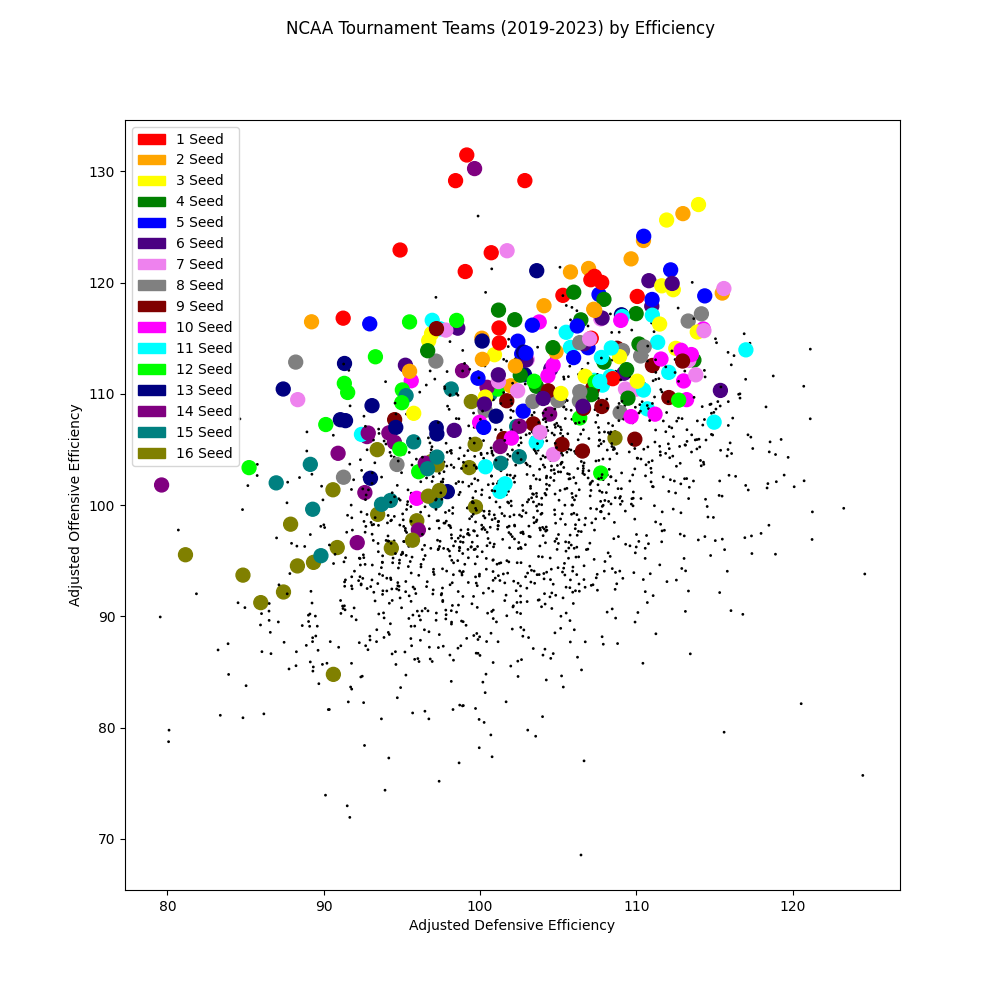

In [18]:
seed_colors = ["#FF0000", "#FFA500", "#FFFF00", "#008000", "#0000FF", "#4B0082", "#EE82EE", "#808080", "#800000", "#FF00FF", "#00FFFF", "#00FF00", "#000080", "#800080", "#008080", "#808000"]
assert len(seed_colors) == 16
plot_colors = [(seed_colors[int(s)-1], 10) if isinstance(s, float) and not np.isnan(s) else ("#000000", 0.1) for s in team_seasons_df["Seed"]]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(team_seasons_df["AdjDE_mean"], team_seasons_df["AdjOE_mean"], c=[c[0] for c in plot_colors], s = [c[1]*10 for c in plot_colors])
ax.legend([patches.Circle((0, 0), 0.1, color = c) for c in seed_colors],[f"{s} Seed" for s in range(1, 17)], loc="upper left")
ax.set_xlabel("Adjusted Defensive Efficiency")
ax.set_ylabel("Adjusted Offensive Efficiency")
fig.suptitle("NCAA Tournament Teams (2019-2023) by Efficiency")
plt.show()

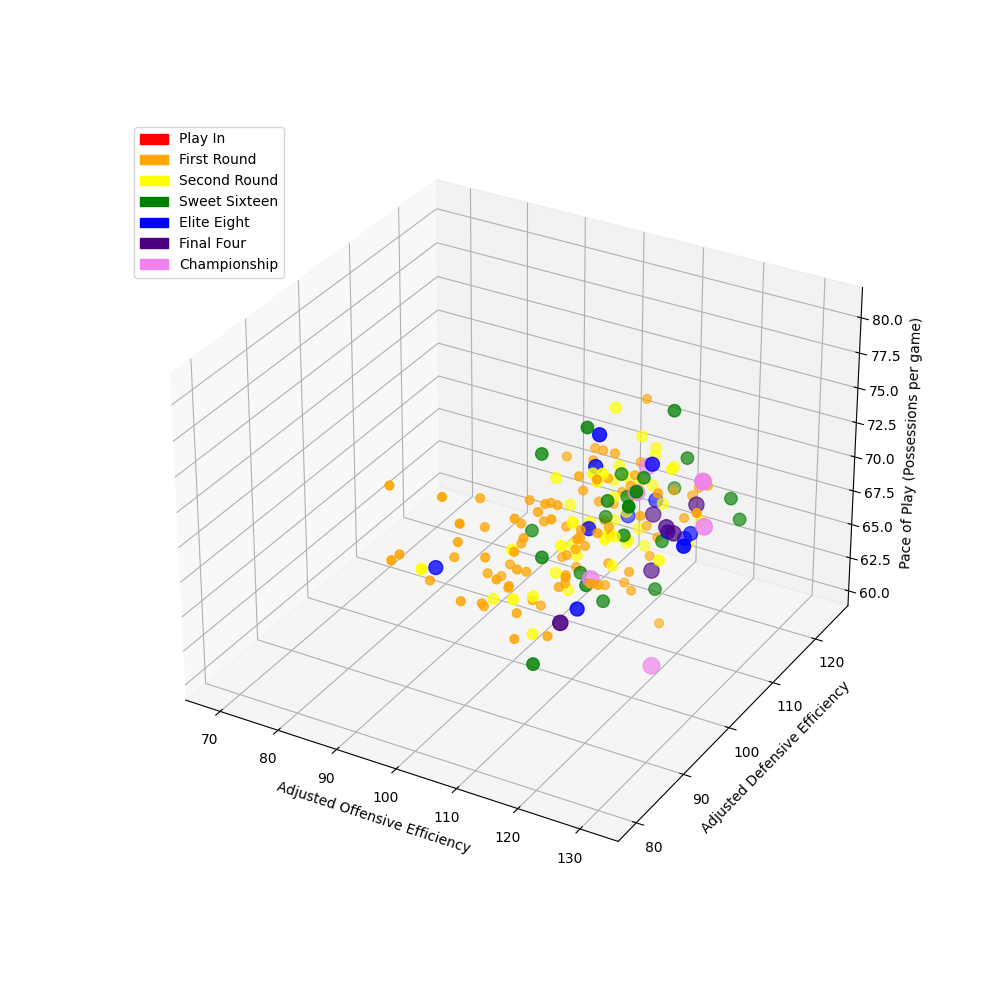

In [30]:
"""Make a scatter plot of Offensive and Defensive Efficiency for each team in the 2022 season
    - color the points by round each team advanced to
"""

plot_x, plot_y, plot_z = team_seasons_df["AdjOE_mean"], team_seasons_df["AdjDE_mean"], team_seasons_df["Poss_mean"]
# print(plot_x, plot_y, plot_z)
# print(f'Evaluating teams in round: {teams_in_round}')
team_rounds = {}
for (team_id, season), team in team_seasons.items():
    if season not in team_rounds:
        team_rounds[season] = {}
    team_eliminated_in = 0
    for round_id, round_teams in teams_in_round.items():
        if season not in round_teams.keys():
            break
        if (round_id == 1) : # Skip the play in rounds that started
            continue
        if team_id not in round_teams[season]:
            break
        team_eliminated_in = round_id
    team_rounds[season][team_id] = team_eliminated_in
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

colors = [seed_colors[team_rounds[szn][tid] - 1] for tid, szn in team_seasons_df[["TeamID", "Season"]].values]
sizes = [20*team_rounds[szn][tid] for tid, szn in team_seasons_df[["TeamID", "Season"]].values]
ax.scatter3D(plot_x, plot_y, plot_z, c = colors, s = sizes)
ax.legend([patches.Circle((0, 0), 0.1, color = seed_colors[round_id-1]) for round_id in range(1, 8)],[f"{ROUND_DAYS[round_id]['Name']}" for round_id in range(1, 8)], loc="upper left")
ax.set_xlabel("Adjusted Offensive Efficiency")
ax.set_ylabel("Adjusted Defensive Efficiency")
ax.set_zlabel("Pace of Play (Possessions per game)")
plt.show()